#### Classification problem

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import time
from datetime import date
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

In [2]:
import _pickle as cPickle
from gensim.models import Word2Vec
import logging

Using TensorFlow backend.


In [3]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

###### Matplotlib settings

In [5]:
mpl.rc('font',family='Times New Roman',size = 25)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2

#### Data Procession

In [18]:
def load_text_csv(filename = 'multimodel/Combined_News_DJIA.csv', date_split = date(2014,12,31)):
    '''
    Load news from csv, group them and split in train/test set due to @date_split
    '''
    df = pd.read_csv(filename)
    df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)

    ## The training set and testing set are not splitted randomly
    train = df.loc[(pd.to_datetime(df["Date"]) <= date_split),['Label','Combined']]
    test = df.loc[(pd.to_datetime(df["Date"]) > date_split),['Label','Combined']]

    return train, test

In [27]:
def data2change(data):
    '''
    Processing data -> new_data = [val/data[0] for val in data]
    '''
    change = pd.DataFrame(data).pct_change()
    change = change.replace([np.inf, -np.inf], np.nan)
    change = change.fillna(0.).values.tolist()
    change = [c[0] for c in change]
    return change

In [28]:
def load_ts_csv(filename = 'multimodel/DJIA_table.csv', date_split = date(2014,12,31)):	
    '''
    Load time series from csv, taking adjustment close prices;
    transforming them into percentage of price change;
    split in train/test set due to @date_split
    '''
    data_original = pd.read_csv(filename)[::-1]
    
    ## The training set and testing set are not splitted randomly
    train2 = data_original.loc[(pd.to_datetime(data_original["Date"]) <= date_split)]
    test2 = data_original.loc[(pd.to_datetime(data_original["Date"]) > date_split)]

    open_train = train2.loc[:, 'Open']
    open_test = test2.loc[:, 'Open']
    print("open_test",type(open_test))
    print(open_test[:5])
    
    open_train = data2change(open_train)
    open_test = data2change(open_test)
    print("open_test after change: ",type(open_test))
    print(open_test[:5])

    high_train = train2.loc[:, 'High']
    high_test = test2.loc[:, 'High']
    print("high_test",type(high_test))
    print(high_test[:5])
    
    high_train = data2change(high_train)
    high_test = data2change(high_test)
    print("high_test after change: ",type(high_test))
    print(high_test[:5])

    low_train = train2.loc[:, 'Low']
    low_test = test2.loc[:, 'Low']
    
    low_train = data2change(low_train)
    low_test = data2change(low_test)

    close_train = train2.loc[:, 'Close']
    close_test = test2.loc[:, 'Close']
    
    close_test = data2change(close_test)
    close_train = data2change(close_train)

    volume_train = train2.loc[:, 'Volume']
    volume_test = test2.loc[:, 'Volume']
    print("volume_test",type(volume_test))
    print(volume_test[:5])

    volume_train = data2change(volume_train)
    volume_test = data2change(volume_test)
    print("volume_test after change: ",type(volume_test))
    print(volume_test[:5])
    
    train = np.column_stack((open_train, high_train, low_train, close_train, volume_train))
    test = np.column_stack((open_test, high_test, low_test, close_test, volume_test))

    print(train.shape)
    print(test.shape)

    return train, test


In [29]:
train, test = load_text_csv()
data_chng_train, data_chng_test = load_ts_csv()
print(test[:5])
print(data_chng_test[:5])

open_test <class 'pandas.core.series.Series'>
377    17823.070312
376    17821.300781
375    17504.179688
374    17374.779297
373    17591.970703
Name: Open, dtype: float64
open_test after change:  <class 'list'>
[0.0, -9.928317450480506e-05, -0.017794497545212673, -0.007392542427378634, 0.012500383589764352]
high_test <class 'pandas.core.series.Series'>
377    17951.779297
376    17821.300781
375    17581.050781
374    17597.080078
373    17916.039062
Name: High, dtype: float64
high_test after change:  <class 'list'>
[0.0, -0.007268277636512832, -0.013481058591196637, 0.0009117371424307574, 0.018125676679664915]
volume_test <class 'pandas.core.series.Series'>
377     76270000
376    116160000
375    101870000
374     91030000
373    114890000
Name: Volume, dtype: int64
volume_test after change:  <class 'list'>
[0.0, 0.5230103579389014, -0.12301997245179064, -0.10641013055855497, 0.26211139184884114]
(1611, 5)
(378, 5)
      Label                                           Combined
1611

In [30]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
        1. Tokenizes and removes punctuation
        2. Removes  stopwords
        3. Stems
        4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return " ".join(text_processed)

In [32]:
def transform_text2sentences(train, test, save_train = 'multimodel/train_text.p', save_test = 'multimodel/test_text.p'):
    '''
    Transforming raw text into sentences,
    if @save_train or @save_test is not None - saves pickles for further use
    :param train:
    :param test:
    :param save_train:
    :param save_test:
    :return:
    '''
    train_text = []
    test_text = []
    for each in train['Combined']:
        train_text.append(text_process(each))
    for each in test['Combined']:
        test_text.append(text_process(each))

    if save_train != None: cPickle.dump(train_text, open(save_train, 'wb')) 
    if save_test != None: cPickle.dump(test_text, open(save_test, 'wb')) 

    return train_text, test_text

In [34]:
def transform_text_into_vectors(train_text, test_text, embedding_size = 100, model_path = 'word2vec10.model'):
    '''
    Transforms sentences into sequences of word2vec vectors
    Returns train, test set and trained word2vec model
    '''
    data_for_w2v = []
    for text in train_text + test_text:
        words = text.split(' ')
        data_for_w2v.append(words)

    model = Word2Vec(data_for_w2v, size=embedding_size, window=5, min_count=1, workers=4)
    model.save(model_path)
    model = Word2Vec.load(model_path)

    train_text_vectors = [[model[x] for x in sentence.split(' ')] for sentence in train_text]
    test_text_vectors = [[model[x] for x in sentence.split(' ')] for sentence in test_text]

    train_text_vectors = [np.mean(x, axis=0) for x in train_text_vectors]
    test_text_vectors = [np.mean(x, axis=0) for x in test_text_vectors]

    return train_text_vectors, test_text_vectors, model

In [36]:
# train_text, test_text = transform_text2sentences(train, test)
train_text = cPickle.load(open('multimodel/train_text.p', 'rb'))[1:]
test_text = cPickle.load(open('multimodel/test_text.p', 'rb'))[1:]

print("Original text: ",type(test_text))
print(test_text[:2])

train_text_vectors, test_text_vectors, model = transform_text_into_vectors(train_text, test_text, 100)
print("text 2 vector: ", type(test_text_vectors))
print(np.shape(test_text_vectors))
print(test_text_vectors[:2])

Original text:  <class 'list'>
['moscow gt beij high speed train reduc trip time 48 hour current 7 day two ancient tomb discov egypt sunday one repres symbol burial site god osiri anoth claim previous unknown pharaon tomb china complain pyongyang n korean soldier kill villag world news scotland head toward fossil fuel free 2030 renew energi project combin energi save could decarbonis countri power sector need see phase convent gener scotland prime minist shinzo abe said monday express remors japan action world war ii highlight countri bid contribut activ world peac statement mark 70th anniversari war end august sex slave centr princ andrew scandal fled australia teen gay rel hama founder face deport canada christian convert 24 whose five uncl jail israel terror activ say hell kill forc return west bank number femal drug addict iran almost doubl sinc 2007 50 start age 15 19 decad search causeway great pyramid egypt found india lost 64 tiger 2014 lizard squad hack soni huge market scheme

In [37]:
def split_into_XY(data_chng_train, train_text_vectors, step, window, forecast):
    '''
    Splits textual and time series data into train or test dataset for hybrid model;
    objective y_i is percentage change of price movement for next day
    '''
    X_train, X_train_text, Y_train, Y_train2 = [], [], [], []
    for i in range(0, len(data_chng_train), step): 
        try:
            x_i = data_chng_train[i:i+window]
            y_i = np.std(data_chng_train[i:i+window+forecast][3])

            text_average = train_text_vectors[i:i+window]
            last_close = x_i[-1]
            y_i2 = None
            if data_chng_train[i+window+forecast][3] > 0.:
                y_i2 = 1.
            else:
                y_i2 = 0.

        except Exception as e:
            print('KEK', e)
            break

        X_train.append(x_i)
        X_train_text.append(text_average)
        Y_train.append(y_i)
        Y_train2.append(y_i2)

    X_train, X_train_text, Y_train, Y_train2 = np.array(X_train), np.array(X_train_text), np.array(Y_train), np.array(Y_train2)
    return X_train, X_train_text, Y_train, Y_train2

In [39]:
X_train, X_train_text, Y_train, Y_train2 = split_into_XY(data_chng_train, train_text_vectors, 1, 30, 1)
X_test, X_test_text, Y_test, Y_test2 = split_into_XY(data_chng_test, test_text_vectors, 1, 30, 1)
print("X_test: ",type(X_test),np.shape(X_test),"\n",X_test[:1])
print("Y_test: ",type(Y_test),np.shape(Y_test),"\n",Y_test[:1])
print("Y_test2: ",type(Y_test2),np.shape(Y_test2),"\n",Y_test2[:1])

KEK index 1611 is out of bounds for axis 0 with size 1611
KEK index 378 is out of bounds for axis 0 with size 378
X_test:  <class 'numpy.ndarray'> (347, 30, 5) 
 [[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
     0.00000000e+00]
  [ -9.92831745e-05  -7.26827764e-03  -1.44022763e-02  -1.85801617e-02
     5.23010358e-01]
  [ -1.77944975e-02  -1.34810586e-02  -1.22202682e-02  -7.42842893e-03
    -1.23019972e-01]
  [ -7.39254243e-03   9.11737142e-04   6.51186144e-03   1.22543927e-02
    -1.06410131e-01]
  [  1.25003836e-02   1.81256767e-02   1.25003836e-02   1.83883108e-02
     2.62111392e-01]
  [  1.81360482e-02  -4.01176844e-05   5.35011924e-03  -9.52095409e-03
    -1.87135521e-01]
  [ -9.43378738e-03  -6.77852536e-03  -6.47456657e-03  -5.44214287e-03
    -9.52992826e-03]
  [ -5.46899855e-03   7.25692771e-03  -4.17433200e-03  -1.53961808e-03
     7.41621622e-02]
  [ -2.03791126e-03  -1.75165457e-02  -1.33344956e-02  -1.05934619e-02
     9.88325282e-02]
  [ -9.810

In [40]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

In [42]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import Merge, Input, concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
main_input = Input(shape=(30, 5), name='ts_input')
lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(main_input)
lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm1)
lstm1 = Flatten()(lstm1)

x2 = Dense(64)(lstm1)
x2 = LeakyReLU()(x2)
x2 = Dropout(0.9)(x2)
x2 = Dense(1, activation = 'sigmoid', name = 'class')(x2)



final_model = Model(inputs=[main_input], 
              outputs=[x2])
opt = Nadam(lr=0.002, clipnorm = 0.5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model.hdf5", verbose=1, save_best_only=True)
final_model.compile(optimizer=opt, loss={'class': 'binary_crossentropy'}, metrics = {'class': 'accuracy'})


for layer in final_model.layers:
    print(layer, layer.output_shape)

<keras.engine.topology.InputLayer object at 0x11b743c18> (None, 30, 5)
<keras.layers.recurrent.LSTM object at 0x11b743be0> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x11b743da0> (None, 30, 10)
<keras.layers.core.Flatten object at 0x11b743d30> (None, 300)
<keras.layers.core.Dense object at 0x11960eba8> (None, 64)
<keras.layers.advanced_activations.LeakyReLU object at 0x120593f28> (None, 64)
<keras.layers.core.Dropout object at 0x102797f60> (None, 64)
<keras.layers.core.Dense object at 0x102797748> (None, 1)


In [46]:
try:
    history = final_model.fit(X_train, Y_train2, 
                epochs = 100, 
                batch_size = 256, 
                verbose=1, 
                validation_data=(X_test, Y_test2),
                callbacks=[reduce_lr, checkpointer],
                shuffle=True)
except Exception as e:
    print(e)

Train on 1580 samples, validate on 347 samples
Epoch 1/100
1580/1580 [==============================] - 4s - loss: 0.9029 - acc: 0.5127 - val_loss: 0.7625 - val_acc: 0.5043
Epoch 2/100
1580/1580 [==============================] - 1s - loss: 0.7537 - acc: 0.5051 - val_loss: 0.6950 - val_acc: 0.4957
Epoch 3/100
1580/1580 [==============================] - 1s - loss: 0.7375 - acc: 0.5019 - val_loss: 0.7130 - val_acc: 0.5043
Epoch 4/100
1580/1580 [==============================] - 1s - loss: 0.7276 - acc: 0.4987 - val_loss: 0.6960 - val_acc: 0.5043
Epoch 5/100
1580/1580 [==============================] - 1s - loss: 0.7366 - acc: 0.5089 - val_loss: 0.7013 - val_acc: 0.5043
Epoch 6/100
1580/1580 [==============================] - 1s - loss: 0.7215 - acc: 0.5006 - val_loss: 0.7190 - val_acc: 0.5043
Epoch 7/100
1580/1580 [==============================] - 1s - loss: 0.7156 - acc: 0.5076 - val_loss: 0.7135 - val_acc: 0.5043
Epoch 8/100
1580/1580 [==============================] - 1s - loss: 0.7

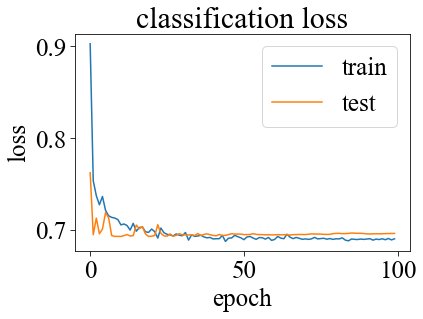

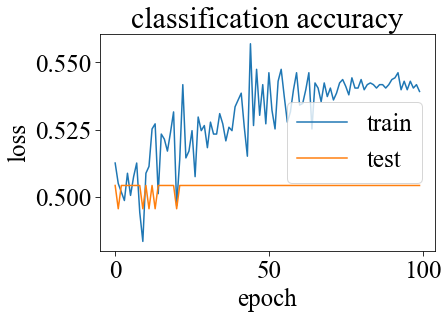

In [47]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('classification accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


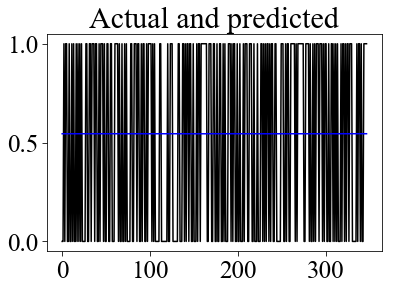

[[ 0.54467136]
 [ 0.54463059]
 [ 0.54467505]
 [ 0.54475802]
 [ 0.54464924]
 [ 0.5447104 ]
 [ 0.54479378]
 [ 0.54480046]
 [ 0.54457098]
 [ 0.54470307]
 [ 0.54456633]
 [ 0.54466152]
 [ 0.54476738]
 [ 0.54462147]
 [ 0.5445953 ]
 [ 0.54478043]
 [ 0.54464537]
 [ 0.54471409]
 [ 0.54474634]
 [ 0.54457605]
 [ 0.54481357]
 [ 0.54473239]
 [ 0.54463744]
 [ 0.54466736]
 [ 0.54442585]
 [ 0.5446462 ]
 [ 0.5449391 ]
 [ 0.54482293]
 [ 0.54462206]
 [ 0.54446453]
 [ 0.54463035]
 [ 0.5445931 ]
 [ 0.54453915]
 [ 0.54448003]
 [ 0.54463881]
 [ 0.54464942]
 [ 0.54460931]
 [ 0.54445243]
 [ 0.54459977]
 [ 0.54481018]
 [ 0.5448038 ]
 [ 0.54486042]
 [ 0.54474479]
 [ 0.54464191]
 [ 0.54479074]
 [ 0.54486912]
 [ 0.54484648]
 [ 0.54470676]
 [ 0.54450649]
 [ 0.54470015]
 [ 0.54473644]
 [ 0.54452777]
 [ 0.54475087]
 [ 0.5446775 ]
 [ 0.54482549]
 [ 0.54473484]
 [ 0.54467636]
 [ 0.54466361]
 [ 0.544734  ]
 [ 0.54471171]
 [ 0.5447349 ]
 [ 0.54465348]
 [ 0.54471898]
 [ 0.5446614 ]
 [ 0.54477668]
 [ 0.54468518]
 [ 0.54477

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [55]:
pred = final_model.predict(X_test)

predicted = pred
original = Y_test2

plt.title('Actual and predicted')
plt.legend(loc='best')
plt.plot(original, color='black', label = 'Original data')
plt.plot(pred, color='blue', label = 'Predicted data')
plt.show()

print((pred))
print(Y_test2)

print(np.mean(np.square(predicted - original)))
print(np.mean(np.abs(predicted - original)))
print(np.mean(np.abs((original - predicted) / original)))